In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import style
import matplotlib
matplotlib.rcdefaults()
import random
import sys
sys.path.insert(1,  '/content/PSM_V1')
import time

In [3]:
class Props:
    def __init__(self,field_val,derivs):
        self.field=field_val
        self.field_derivative=derivs


#----------------------------------------------------#
class Particle:
    def __init__(self,position,properties):
        self.position=position
        self.properties=properties

    def interact(self,other_particle):
        pass

    def evolve(self):
        pass

#----------------------------------------------------#
class ParticleSet:
    # positions: array of shape(N,d)
    # properties: array of shape(N,1)

    def __init__(self,positions,properties):
        self.num_particles = positions.shape[0]
        self.spatial_dimension = positions.shape[1]
        self.particles=[]
        for i in range(self.num_particles):
            self.particles.append(Particle(positions[i,:],properties[i]))

    def update_once(self):
        pass


In [153]:
'''
Overall, the CellList class provides methods to construct a cell-based data structure for particles,
retrieve particles within a specific cell, and obtain a neighborhood of particles around a given cell
'''

class CellList:

    def __init__(self, particle_set, rc):
        self.cells = {}
        self.construct(particle_set, rc)
        self.particle_set = particle_set

    def construct(self, particle_set, rc):
        for idx, p in enumerate(particle_set.particles):
            cell_index_x, cell_index_y = np.floor((p.position) / rc).astype(int)
            cell_index = (cell_index_x, cell_index_y)
            if cell_index in self.cells.keys():
                self.cells[cell_index].append(idx)
            else:
                self.cells[cell_index] = [idx]

    def particles_in(self, cell_index):
        if cell_index in self.cells.keys():
            return self.cells[cell_index]
        else:
            return []

    def neighbourhood(self, cell_index):
        cell_index_x, cell_index_y = cell_index
        neighbour_list = []
        for lx in [-1, 0, 1]:
            for ly in [-1, 0, 1]:
                neighbour_list.extend(self.particles_in((cell_index_x + lx, cell_index_y + ly)))

        return neighbour_list

    def affected_cells(self,shock_ini,shock_final):
        m1=shock_ini[0]
        b1=shock_ini[1]

        m2=shock_final[0]
        b2=shock_final[1]

        if(m1>m2):
          temp=m1
          m1=m2
          m2=temp

          temp=b1
          b1=b2
          b2=temp

        X=np.linspace(x_l,x_r,N)
        cells_affected=[]

        for i in range(N):
           x=np.floor((X[i]) / rc).astype(int)
           Y1=np.floor((m1*(X[i])+b1) / rc).astype(int)
           Y2=np.floor((m2*(X[i])+b2) / rc).astype(int)
           temp=Y1
           Y1=min(Y1,Y2)
           Y2=max(temp,Y2)
           y_min=max(Y1,np.floor((y_l) / rc).astype(int))#bottommost affected point
           y_max=min(Y2,np.floor((y_r) / rc).astype(int))#topmost affected point

           for j in range(y_min,y_max+1):
             cells_affected.append((x,j))

        #removing duplicates if any
        cells_affected = list( dict.fromkeys(cells_affected) )
        return cells_affected

    def affected_particles(self, shock_ini,shock_final):

      cells=self.affected_cells(shock_ini,shock_final)
      particles_idx_affected=[]
      for x in cells:
        p=self.particles_in(x)
        for idx in p:
          particles_idx_affected.append(idx)
      return particles_idx_affected

    def coord_affected(self,shock_ini,shock_final):
      affected=self.affected_particles(shock_ini, shock_final)
      affected_pos=[]
      for p in affected:
        affected_pos.append(self.particle_set.particles[p].position)
      return affected_pos

In [154]:
'''
def cells_affected(shock_ini, shock_final):
    m0=shock_ini[0]
    b0=shock_ini[1]

    m1=shock_final[0]
    b1=shock_final[1]
    coord_for_cells1=[]
    coord_for_cells2=[]

    eps=0.01
    x0,y0=0,b0
    x1,y1=0,b1

    while(x0 <1 and y0 <1):
        x0+=1*eps
        y0+=m0*eps
        coord_for_cells1.append([x0,y0])

    while(x1 <1 and y1 <1):
        x1+=1*eps
        y1+=m1*eps
        #print(np.floor((x1,y1)/rc).astype(int))
        coord_for_cells2.append([x1,y1])
    print(x0,y0,"-",x1,y1)
    return np.array(coord_for_cells1),np.array(coord_for_cells2)
    '''

'\ndef cells_affected(shock_ini, shock_final):\n    m0=shock_ini[0]\n    b0=shock_ini[1]\n\n    m1=shock_final[0]\n    b1=shock_final[1]\n    coord_for_cells1=[]\n    coord_for_cells2=[]\n\n    eps=0.01\n    x0,y0=0,b0\n    x1,y1=0,b1\n\n    while(x0 <1 and y0 <1):\n        x0+=1*eps\n        y0+=m0*eps\n        coord_for_cells1.append([x0,y0])\n\n    while(x1 <1 and y1 <1):\n        x1+=1*eps\n        y1+=m1*eps\n        #print(np.floor((x1,y1)/rc).astype(int))\n        coord_for_cells2.append([x1,y1])\n    print(x0,y0,"-",x1,y1)\n    return np.array(coord_for_cells1),np.array(coord_for_cells2)\n    '

In [155]:
'''
N=100
rc=0.1
def find_ys_for_x(data_list, x):
    ys = [y for (x_val, y) in data_list if x_val == x]
    return ys

def give_cells(shock_ini,shock_final):
  m1=shock_ini[0]
  b1=shock_ini[1]

  m2=shock_final[0]
  b2=shock_final[1]

  if(m1>m2):
    temp=m1
    m1=m2
    m2=temp

  X=np.linspace(0,1,N)
  #Y1=m1*(X)+b1
  #Y2=m2*(X)+b2

  #cells=[]
  #for i in range(10):
  #  x=np.floor((X[i]) / rc).astype(int)
  #  cells.append((x,min(np.floor((Y1[i]) / rc).astype(int),np.floor((1) / rc).astype(int))))
  #  cells.append((x,min(np.floor((Y2[i]) / rc).astype(int),np.floor((1) / rc).astype(int))))
  #print(cells)
  cells_affected=[]
  for i in range(N):
    x=np.floor((X[i]) / rc).astype(int)
    Y1=np.floor((m1*(X[i])+b1) / rc).astype(int)
    Y2=np.floor((m2*(X[i])+b2) / rc).astype(int)
    y_min=max(Y1,np.floor((-1) / rc).astype(int))
    y_max=min(Y2,np.floor((1) / rc).astype(int))
    #ys=find_ys_for_x(c,x)
    #print((x,ys))
    #y_min=min(ys)
    #y_max=max(ys)
    for i in range(y_min,y_max):
      cells_affected.append((x,i))

  return cells_affected
  '''

'\nN=100\nrc=0.1\ndef find_ys_for_x(data_list, x):\n    ys = [y for (x_val, y) in data_list if x_val == x]\n    return ys\n\ndef give_cells(shock_ini,shock_final):\n  m1=shock_ini[0]\n  b1=shock_ini[1]\n\n  m2=shock_final[0]\n  b2=shock_final[1]\n\n  if(m1>m2):\n    temp=m1\n    m1=m2\n    m2=temp\n\n  X=np.linspace(0,1,N)\n  #Y1=m1*(X)+b1\n  #Y2=m2*(X)+b2\n\n  #cells=[]\n  #for i in range(10):\n  #  x=np.floor((X[i]) / rc).astype(int)\n  #  cells.append((x,min(np.floor((Y1[i]) / rc).astype(int),np.floor((1) / rc).astype(int))))\n  #  cells.append((x,min(np.floor((Y2[i]) / rc).astype(int),np.floor((1) / rc).astype(int))))\n  #print(cells)\n  cells_affected=[]\n  for i in range(N):\n    x=np.floor((X[i]) / rc).astype(int)\n    Y1=np.floor((m1*(X[i])+b1) / rc).astype(int)\n    Y2=np.floor((m2*(X[i])+b2) / rc).astype(int)\n    y_min=max(Y1,np.floor((-1) / rc).astype(int))\n    y_max=min(Y2,np.floor((1) / rc).astype(int))\n    #ys=find_ys_for_x(c,x)\n    #print((x,ys))\n    #y_min=min(ys)\

In [156]:
'''
c=give_cells(np.array((3,0.0)),np.array((1,0.0)))
affc=cells_affected(np.array((3,0.0)),np.array((1,0.)))
affc1,affc2=np.array(affc)
x1,y1=affc1[:,0],affc1[:,1]
x2,y2=affc2[:,0],affc2[:,1]
plt.scatter(x1,y1)
plt.scatter(x2,y2,color='red')
'''

"\nc=give_cells(np.array((3,0.0)),np.array((1,0.0)))\naffc=cells_affected(np.array((3,0.0)),np.array((1,0.)))\naffc1,affc2=np.array(affc)\nx1,y1=affc1[:,0],affc1[:,1]\nx2,y2=affc2[:,0],affc2[:,1]\nplt.scatter(x1,y1)\nplt.scatter(x2,y2,color='red')\n"

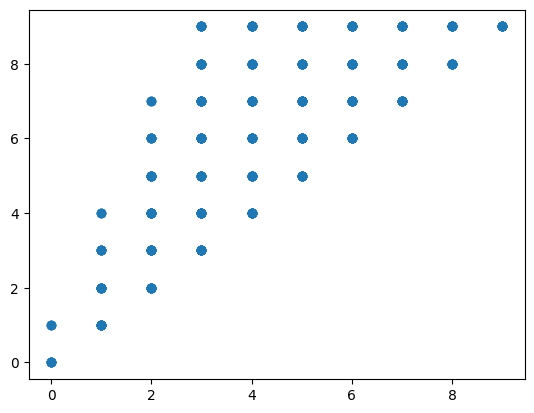

In [157]:
c=np.array(c)
x=c[:,0]
y=c[:,1]
plt.scatter(x,y)

In [158]:
N = 100
d = 2
x_l=0
x_r=1
y_l=0
y_r=1
x=np.linspace(x_l,x_r,N)
y=np.linspace(y_l,y_r,N)
h=x[1]-x[0]
eps=2*h
rc = 5.0*h
nx,ny=np.meshgrid(x,y)
nx=np.reshape(nx,-1)
ny=np.reshape(ny,-1)
positions=np.concatenate([nx[:, None], ny[:, None]], axis=1)
properties=[]
for i in range(len(positions)):
  properties.append(Props(0.,0.))
pset=ParticleSet(positions,properties)

#print(pset.particles[50].position)
#print(pset.particles[0].properties.field)
celllist=CellList(pset,rc)

In [162]:
m1=-1.
b1=1.5

m2=-0.5
b2=0.5
shock_ini=np.array((m1,b1))
shock_final=np.array((m2,b2))
affc=celllist.coord_affected(shock_ini,shock_final)

In [163]:
def line(x,m,b):
  return m*x+b

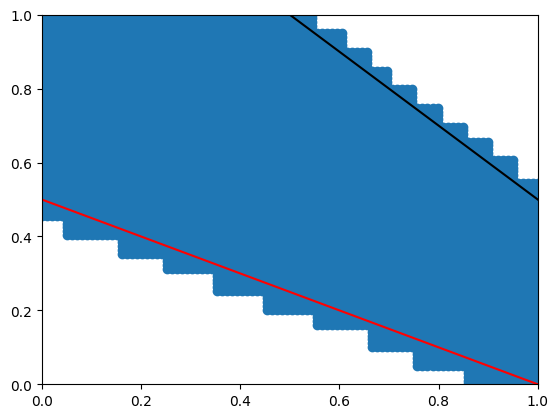

In [164]:
aff=np.array(affc)
plt.plot(x,line(x,m1,b1),color='black')
plt.plot(x,line(x,m2,b2),color='red')
x1,y1=aff[:,0],aff[:,1]
plt.scatter(x1,y1)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()